# Speed Dating and the Dynamics of a Successful Match

Link to dataset on OpenML.org including description of variables: https://www.openml.org/d/40536

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('./data/speed-dating.csv')

In [3]:
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21.0,27.0,6,[4-6],'asian/pacific islander/asian-american',european/caucasian-american,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,0,1,female,21.0,22.0,1,[0-1],'asian/pacific islander/asian-american',european/caucasian-american,0,...,[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,1,1,female,21.0,22.0,1,[0-1],'asian/pacific islander/asian-american','asian/pacific islander/asian-american',1,...,[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0,1,1,1
3,0,1,female,21.0,23.0,2,[2-3],'asian/pacific islander/asian-american',european/caucasian-american,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,1,1
4,0,1,female,21.0,24.0,3,[2-3],'asian/pacific islander/asian-american','latino/hispanic american',0,...,[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1,1,1


In [4]:
df.shape

(8378, 123)

In [5]:
df.columns

Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
       'race', 'race_o', 'samerace',
       ...
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'like',
       'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision',
       'decision_o', 'match'],
      dtype='object', length=123)

###### <br>

## Data cleaning

A significant portion of columns, specifically the ones that start with 'd_', are columns that act as the nominal counterparts to certain columns. Will be removing them due to limited usefulness for our case, and to reduce dimensions when fitting a model.

In [6]:
# Renaming column to avoid being filtered out by ensuing regular expression
df = df.rename(columns={'d_age': 'dif_age'})

In [7]:
# Dropping all columns prefixed with 'd_'
df = df.loc[:,~df.columns.str.startswith('d_')]
df.shape

(8378, 68)

In [8]:
# Drop columns with more than half null values
df = df.dropna(thresh=(0.5 * len(df)), axis=1)
df.shape

(8378, 67)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   wave                           8378 non-null   int64  
 2   gender                         8378 non-null   object 
 3   age                            8283 non-null   float64
 4   age_o                          8274 non-null   float64
 5   dif_age                        8378 non-null   int64  
 6   race                           8315 non-null   object 
 7   race_o                         8305 non-null   object 
 8   samerace                       8378 non-null   int64  
 9   importance_same_race           8299 non-null   float64
 10  importance_same_religion       8299 non-null   float64
 11  field                          8315 non-null   object 
 12  pref_o_attractive              8289 non-null   f

###### <br>

'Field', 'Race', 'Race_o' are the only non-numerical columns with a relatively low amount of null values. Dropping rows with null values on either of the three aforementioned columns. Also choosing not to fill null values on 'field' with 'no field' since I am not sure whether there was an option for 'no field' on the survey.

In [10]:
# Fix typos on a few columns names
df = df.rename(columns={'sinsere_o': 'sincere_o',
                       'ambitous_o': 'ambitious_o',
                       'intellicence_important': 'intelligence_important',
                       'ambtition_important': 'ambition_important'})

In [11]:
df = df.dropna(subset=['field', 'race', 'race_o'], axis=0).reset_index()
df.shape

(8242, 68)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8242 entries, 0 to 8241
Data columns (total 68 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          8242 non-null   int64  
 1   has_null                       8242 non-null   int64  
 2   wave                           8242 non-null   int64  
 3   gender                         8242 non-null   object 
 4   age                            8211 non-null   float64
 5   age_o                          8211 non-null   float64
 6   dif_age                        8242 non-null   int64  
 7   race                           8242 non-null   object 
 8   race_o                         8242 non-null   object 
 9   samerace                       8242 non-null   int64  
 10  importance_same_race           8226 non-null   float64
 11  importance_same_religion       8226 non-null   float64
 12  field                          8242 non-null   o

In [13]:
# Check age columns to see if missing data can be filled with simple arithmetic
age = df[df['age'].isnull()].loc[:, ['age', 'age_o', 'dif_age']]
age.head()

,age,age_o,dif_age
1769,NaN,20.0,20
1770,NaN,21.0,21
1771,NaN,20.0,20
1772,NaN,21.0,21
1773,NaN,21.0,21


In [14]:
age_o = df[df['age_o'].isnull()].loc[:, ['age', 'age_o', 'dif_age']]
age_o.head()

,age,age_o,dif_age
1623,20.0,NaN,20
1633,21.0,NaN,21
1643,20.0,NaN,20
1653,21.0,NaN,21
1663,21.0,NaN,21


Looking at rows with either null 'age' or null 'age_o', it appears the age difference column merely copies the non-null age column instead of providing a difference value, which makes sense since there should be no data to compute the difference off of. Based on findings, dropping rows with a null value in either 'age' or 'age_o'.

In [15]:
df = df.dropna(subset=['age', 'age_o'], axis=0).reset_index()
df.shape

(8180, 69)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180 entries, 0 to 8179
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   level_0                        8180 non-null   int64  
 1   index                          8180 non-null   int64  
 2   has_null                       8180 non-null   int64  
 3   wave                           8180 non-null   int64  
 4   gender                         8180 non-null   object 
 5   age                            8180 non-null   float64
 6   age_o                          8180 non-null   float64
 7   dif_age                        8180 non-null   int64  
 8   race                           8180 non-null   object 
 9   race_o                         8180 non-null   object 
 10  samerace                       8180 non-null   int64  
 11  importance_same_race           8164 non-null   float64
 12  importance_same_religion       8164 non-null   f

###### <br>

Looking at the numerical columns through https://www.openml.org/d/40536, most numerical columns have a relatively high spread. Since there is no inherent connection (such as being part of a time series) between top and bottom rows, will fill null values with the respective column medians.

In [17]:
# Filling the rest of the null values by median
df = df.fillna(df.median())
df.isnull().sum().sum()

0

In [18]:
# Dropping 'has_null', 'wave', 'level_0' due to lack of usefulness
df = df.drop(columns=['level_0', 'index', 'has_null', 'wave'])
df.shape

(8180, 65)

##### Cleaned:
Through repeatedly looking at the data and keeping in mind the necessary elements moving forward, I started with a patchy dataset of **(8378, 123)**, and ended up with a clean dataset of **(8180, 65)**.

##### Simplify names:
Look to reduce wordiness in 'race' and 'race_o' columns.

In [19]:
df['race'].unique()

array(["'asian/pacific islander/asian-american'",
       'european/caucasian-american', 'other',
       "'latino/hispanic american'", "'black/african american'"],
      dtype=object)

In [20]:
simplify_race = {"'asian/pacific islander/asian-american'": 'asian',
                'european/caucasian-american': 'caucasian',
                "'latino/hispanic american'": 'latino',
                "'black/african american'": 'black',
                'other': 'other'}

df['race'] = df['race'].map(simplify_race)
df['race_o'] = df['race_o'].map(simplify_race)

In [21]:
df['race'].unique()

array(['asian', 'caucasian', 'other', 'latino', 'black'], dtype=object)

###### <br>

In [22]:
df.head()

,gender,age,age_o,dif_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,...,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,like,guess_prob_liked,met,decision,decision_o,match
0,female,21.0,27.0,6,asian,caucasian,0,2.0,4.0,law,...,1.0,0.14,3.0,4.0,7.0,6.0,0.0,1,0,0
1,female,21.0,22.0,1,asian,caucasian,0,2.0,4.0,law,...,1.0,0.54,3.0,4.0,7.0,5.0,1.0,1,0,0
2,female,21.0,22.0,1,asian,asian,1,2.0,4.0,law,...,1.0,0.16,3.0,4.0,7.0,5.0,1.0,1,1,1
3,female,21.0,23.0,2,asian,caucasian,0,2.0,4.0,law,...,1.0,0.61,3.0,4.0,7.0,6.0,0.0,1,1,1
4,female,21.0,24.0,3,asian,latino,0,2.0,4.0,law,...,1.0,0.21,3.0,4.0,6.0,6.0,0.0,1,1,1


###### <br>

## Age distribution across gender & race

In [23]:
# Sub-dataframe to examine gender, age, and race
df_age = df[['gender', 'age', 'race']]

In [24]:
# Look at participant percentage of each gender
df_age['gender'].value_counts()/len(df_age)

male      0.5
female    0.5
Name: gender, dtype: float64

In [25]:
# Look at participant percentage or each race
df_age['race'].value_counts()/len(df_age)

caucasian    0.566993
asian        0.239487
latino       0.080073
other        0.062836
black        0.050611
Name: race, dtype: float64

''

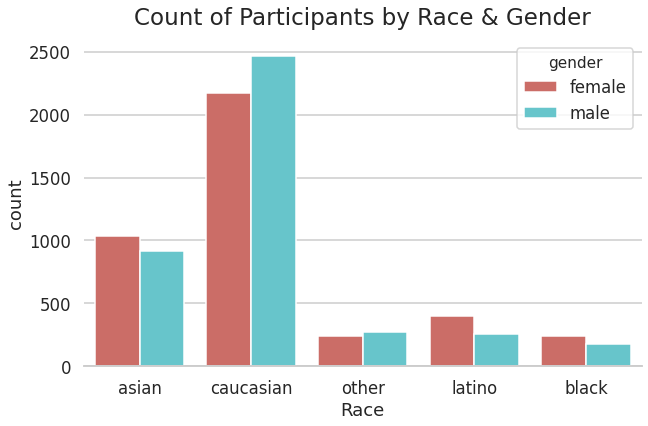

In [26]:
# Count plot of gender and race
plt.figure(figsize=(10,6))
sns.set(style='whitegrid', color_codes=True, context='talk')
sns.countplot(x='race', hue='gender', data=df_age,
             palette='hls')
plt.title('Count of Participants by Race & Gender', size=23, y=1.03)
plt.xlabel('Race')
sns.despine(left=True)
plt.savefig('./figure/count_by_race_gender.png')
;

''

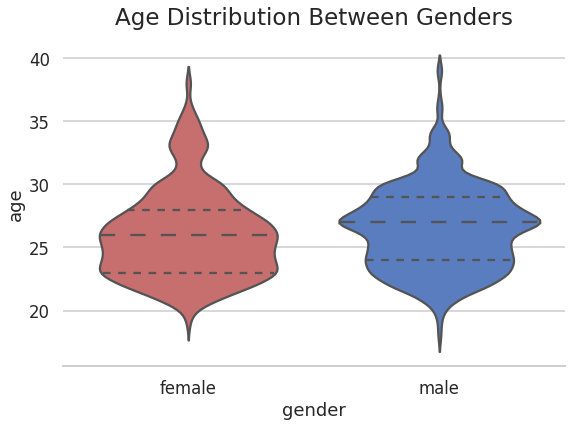

In [27]:
# Violin plot to check age distribution between genders
sns.set(style="whitegrid", palette="muted", color_codes=True, context='talk')
plt.figure(figsize=(9,6))
sns.violinplot(x='gender', y='age', data=df_age[df_age.age<=40], # Limiting age within 40 due to few outliers
               inner='quartile', palette={'female': 'r', 'male': 'b'})
plt.title('Age Distribution Between Genders', size=23, y=1.03)
sns.despine(left=True)
plt.savefig('./figure/age_dist_by_gender.png')
;

While there is equal represenation of gender, race is mostly dominated by caucasians **(57%)** and secondly asians **(24%)**. There are also notably more female participants within the caucasian group.

Age distributions of genders are both bottom-heavy, with females centered around **26** years old and males at around **27**. This is about the time that most people start to worry about establishing a stable relationship. It would be interesting if we had data for the participants' *level of education*, since 26-27 years old is usually around the time when most people complete a graduate degree.

##### Sidenote:
It could be argued that the female distribution has a second mean centered around age 33, which could be due to pure chance.

###### <br>

## Examination of interests (across genders)

In [28]:
# Create new dataframe with all interest columns as well as gender & race
interest_cols = ['gender', 'race', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', \
                'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', \
                'music', 'shopping', 'yoga']

interests_df = df[interest_cols]

In [29]:
interests_df.head()

,gender,race,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
0,female,asian,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
1,female,asian,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
2,female,asian,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
3,female,asian,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
4,female,asian,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0


In [30]:
# Average values based on gender and sort by sum
interests_g = interests_df.drop(columns=['race']).groupby('gender').mean().T
interests_g['sum'] = interests_g['female'] + interests_g['male']   # Create sum column
interests_g = interests_g.sort_values(by=['sum'], ascending=False) \
                         .reset_index() \
                         .rename(columns={'gender': 'index', 'index': 'interest'})
interests_g['interest'] = interests_g['interest'].str.capitalize()

In [31]:
# 'Pivot table' that compares interest ratings between genders and sorted by the total
interests_g.set_index('interest')

gender,female,male,sum
interest,,,
Movies,8.192910,7.646210,15.839120
Music,7.972127,7.714425,15.686553
Dining,8.147922,7.417848,15.565770
Reading,7.897800,7.455746,15.353545
Museums,7.416870,6.559658,13.976528
Concerts,7.096577,6.545232,13.641809
Theater,7.460880,6.092421,13.553301
Art,7.202200,6.223472,13.425672
Sports,5.848166,7.025917,12.874083


In [32]:
# Comparing the mean ratings between genders
male_mean = interests_g['male'].mean()
female_mean = interests_g['female'].mean()
print('Male mean: ', male_mean)
print('Female mean: ', female_mean)

Male mean:  6.034862649216166
Female mean:  6.485574572127139


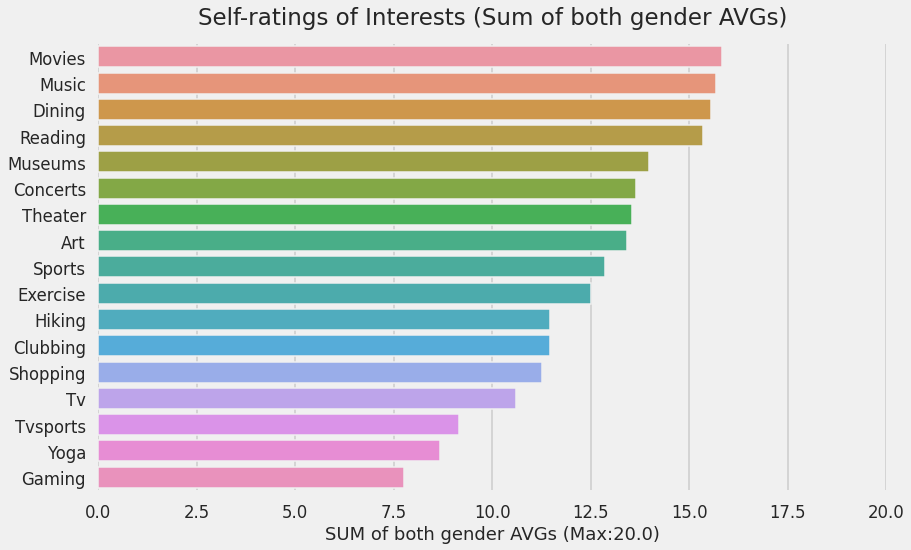

In [33]:
# Plot bar chart of the sum of interest ratings
plt.style.use('fivethirtyeight')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(13,8))
sns.barplot(y='interest', x='sum', data=interests_g)
plt.ylabel('')
plt.xlabel('SUM of both gender AVGs (Max:20.0)')
ax.set(xlim=(0,20))
plt.title('Self-ratings of Interests (Sum of both gender AVGs)', size=23, y=1.03)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./figure/interests_self_ratings.png')

In [34]:
# Melt interests_g to prep for grouped bar chart
interests_g2 = interests_g.drop(columns=['sum']) \
                          .melt(id_vars='interest', var_name='gender', value_name='avg_rating')

''

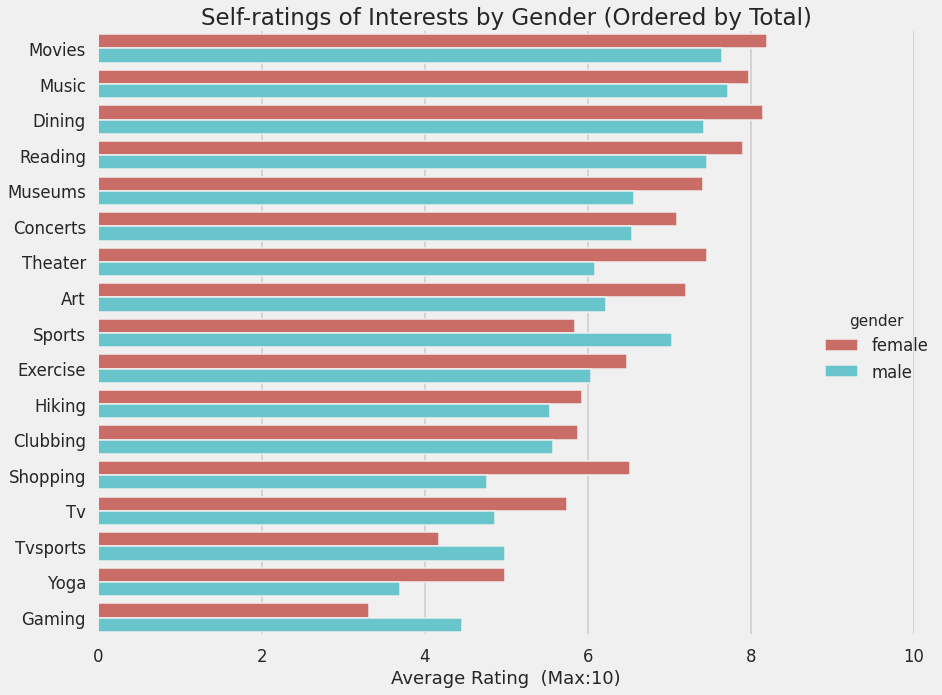

In [35]:
# Plot grouped bar chart split by gender
sns.catplot(y='interest', x='avg_rating', hue='gender', data=interests_g2,
           kind='bar', height=10, aspect=7/6, palette='hls')
plt.xlim(0,10)
plt.xlabel('Average Rating  (Max:10)')
plt.ylabel('')
plt.title('Self-ratings of Interests by Gender (Ordered by Total)', size=23, y=1.03)
plt.tight_layout()
plt.savefig('./figure/interests_self_ratings_by_gender.png')
;

##### Top 5 popular interests:
1. Movies
- Music
- Dining
- Reading
- Museums

##### Bottom 3 interests that failed to score higher than 10 ('neutral' point on survey)
- Gaming
- Yoga
- TV Sports

##### Female-leaning interests:
- Yoga
- Shopping
- Art
- Theater

##### Male-leaning interests:
- Gaming
- TV Sports
- Sports

Most observations from the two graphs do not necessarily challenge our day-to-day expectations of the distribution of people's interests, though it could be argued that there is some incentive for participants to adjust their self-ratings to appear more desirable in a speed-dating setting. This could have resulted in:
- higher self-ratings in the more positively viewed interests such as *reading* and *museums*
- lower self-ratings in *clubbing* or *gaming*, interests that are somewhat associated with immaturity

Male and female leaning interests mostly fit their respective social images, with females more interested in *yoga* and *shopping*, whereas males are more interested in *gaming* and *sports*. A curious observation is that while females are generally less interested in *sports* and *TV sports*, they rated higher on *exercise* and *TV*, which balances out gender differences when it comes to general exercise and watching TV. Of course, this is assuming *TV* and *exercise* are inclusive of *TV sports* and *sports* respectively.
<br>
<br>
It should also be noted that females have an overall higher self-rating across all interests with an average of **6.49** against the male average of **6.03**, which could lead to other interesting interpretations. e.g. Do males have less interest overall, or do they tend to under-report?

###### <br>

## How race affects emphasis on preference for the same race and religion

In [36]:
race_cols = ['race', 'importance_same_race', 'importance_same_religion']
df_r = df[race_cols]
df_r.head()

,race,importance_same_race,importance_same_religion
0,asian,2.0,4.0
1,asian,2.0,4.0
2,asian,2.0,4.0
3,asian,2.0,4.0
4,asian,2.0,4.0


In [37]:
# Check ranges to make sure both columns are on the same 0-10 scale
df_r.describe()

,importance_same_race,importance_same_religion
count,8180.000000,8180.000000
mean,3.794988,3.671027
std,2.845949,2.806942
min,0.000000,1.000000
25%,1.000000,1.000000
50%,3.000000,3.000000
75%,6.000000,6.000000
max,10.000000,10.000000


''

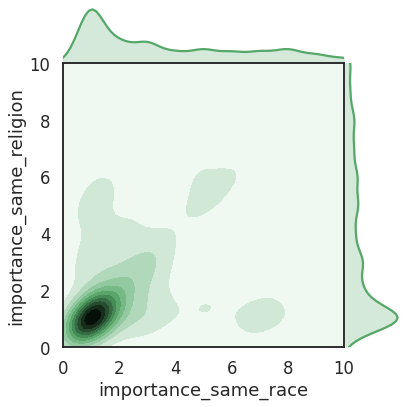

In [38]:
# Create jointplot to visualize distributions and relationship of the two 'importance' columns
sns.set(style='white', color_codes=True, context='talk')
sns.jointplot('importance_same_race', 'importance_same_religion', data=df_r, kind='kde',
             xlim=(0,10), ylim=(0,10), space=0, color='g')
plt.savefig('./figure/race_gender_jointplot.png')
;

In [39]:
# Rename and melt to prep for grouped bar plot
plot_r = df_r.rename(columns={'importance_same_race': 'same_race',
                              'importance_same_religion': 'same_religion'}) \
             .melt(id_vars='race', var_name='importance_type', value_name='importance_rating')
plot_r.head()

,race,importance_type,importance_rating
0,asian,same_race,2.0
1,asian,same_race,2.0
2,asian,same_race,2.0
3,asian,same_race,2.0
4,asian,same_race,2.0


In [40]:
# Group-by chart before plotting
plot_r.groupby(by=['race', 'importance_type']).mean()

importance_rating
race      importance_type                   
asian     same_race                 3.467075
          same_religion             3.127106
black     same_race                 3.359903
          same_religion             2.821256
caucasian same_race                 4.210651
          same_religion             4.022639
latino    same_race                 2.749618
          same_religion             3.386260
other     same_race                 2.976654
          same_religion             3.618677

''

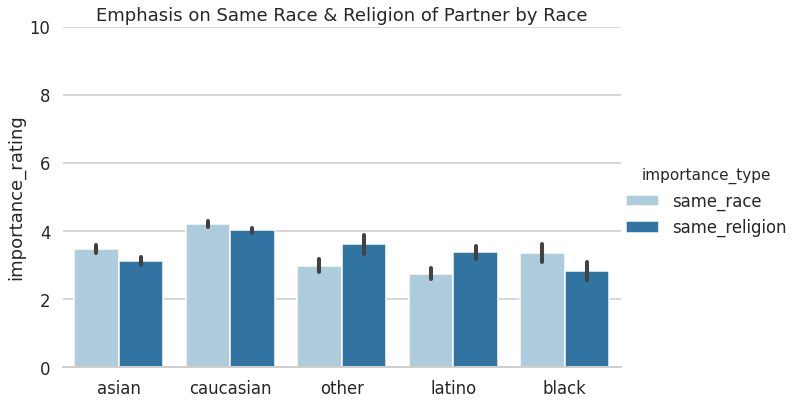

In [41]:
# Draw grouped bar chart to look at average emphasis by race
sns.set(style='whitegrid', color_codes=True, context='talk')
sns.catplot(x='race', y='importance_rating', hue='importance_type', data=plot_r,
           kind='bar', palette='Paired', height=6, aspect=3/2)
plt.xlabel('')
plt.ylim(0,10)
plt.title('Emphasis on Same Race & Religion of Partner by Race')
sns.despine(left=True)
plt.savefig('./figure/emphasis_same_race_religion_by_race.png')
;

From the kde joint plot we can see that most participants have little to no preference on their partner having the same race and religion with most data points lying within a square from (0,0) to (2,2). 

Looking at the grouped bar plot, there are slight discrepancies between races as to their preferences. From what little differences are presented:
- *Asians*, *caucasians*, and *blacks* have a higher preference for finding someone of the **same race**.
- *Other races* and *latinos* have a heavier emphasis on finding a partner of the **same religion**.
- *Caucasians* seem to have a slightly higher preference for both attributes.

###### <br>

## Correlation Matrix

Both the correlation matrix and the eventual model fitting will require certain column trimming and transformations. There are a few issues that need to be addressed:
#### **Unneeded columns**:
- **'expected_happy_with_sd_people'** - likely collinear with 'expected_num_matches'
- **'like', 'guess_prob_liked'** - unreliable variables. Will be hard to draw conclusions from.
- **'importance_same_race', 'importance_same_religion'** - Found to be low variance variables
- **'decision', 'decision_o'** - Redundant due to their relationships to target variable 'match'
- **\*Interest columns**: The individual self-ratings of interests will likely not make it into the correlation matrix nor the model since they are already captured within the 'interests_correlate' column.

#### **Transformations**:
- **'dif_age'**: The 'dif_age' column as it is now has no direction. It is currently the *absolute value* of the difference in age between the two partners. It will make more sense to have a new column reflect (male's age - female's age) to give it a direction while also removing the need to have all three columns ('age', 'age_o', 'dif_age') present.
- **'race'**: 'race' and 'race_o' will likely be condensed into two binary columns for *Caucasian* and *Asian* pertaining to the subject only. 'samerace' will be kept.
- **'field'**: The 'field' column contains 219 unique values. Assuming it is used, it will likely be encoded into a few binary columns of the most popular fields.
- **'gender'**: The 'gender' column will need to be dummified.

#### **Aggregated Ratings**:
Aggregated ratings need to be created, more so for the correlation matrix, to reduce the dimension. There are five categories of ratings that all have unique prefixes or suffixes or lack thereof:
- How important the partner rates certain traits ['pref_o']
- Partner ratings of subject ['_o']
- What the subject looks for in partner ['_important']
- Subject self-ratings ['']
- Subject ratings of partner ['_partner']

In [42]:
df.columns

Index(['gender', 'age', 'age_o', 'dif_age', 'race', 'race_o', 'samerace',
       'importance_same_race', 'importance_same_religion', 'field',
       'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
       'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o',
       'shared_interests_o', 'attractive_important', 'sincere_important',
       'intelligence_important', 'funny_important', 'ambition_important',
       'shared_interests_important', 'attractive', 'sincere', 'intelligence',
       'funny', 'ambition', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner',
       'shared_interests_partner', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'interests_correlate', 'expected_happy_with_sd_

In [43]:
cols_drop = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', \
             'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', \
             'music', 'shopping', 'yoga', 'importance_same_race', 'importance_same_religion', \
             'expected_happy_with_sd_people', 'like', 'guess_prob_liked', 'decision', \
             'decision_o', 'dif_age', 'race_o']

df_conv = df.drop(columns=cols_drop)

In [44]:
# Encode a 'female_age' column
df_conv['f_age'] = ''
df_conv.loc[df_conv['gender']=='female', 'f_age'] = df_conv['age']
df_conv.loc[df_conv['gender']=='male', 'f_age'] = df_conv['age_o']

# Encode column that represents the male's age minus the female's
df_conv['m_to_f_agediff'] = ''
df_conv.loc[df_conv['gender']=='female', 'm_to_f_agediff'] = df_conv['age_o'] - df_conv['age']
df_conv.loc[df_conv['gender']=='male', 'm_to_f_agediff'] = df_conv['age'] - df_conv['age_o']

# Drop 'age' and 'age_o'
df_conv = df_conv.drop(columns=['age', 'age_o'])

In [45]:
# Encode two dummy columns to replace race
df_conv['caucasian'] = df_conv['race'].apply(lambda x: 1 if x=='caucasian' else 0)
df_conv['asian'] = df_conv['race'].apply(lambda x: 1 if x=='asian' else 0)

# Drop 'race'
df_conv = df_conv.drop(columns=['race'])

In [46]:
# Check top 4 most common fields to prepare for dummification
df_conv['field'].value_counts()[:4]

business         624
law              595
mba              452
'social work'    414
Name: field, dtype: int64

In [47]:
# Stripping single quotes from 'social work'
df_conv.loc[df_conv['field']=="'social work'", 'field'] = 'social work'

# Dummify top 4 most common fields
field_vals = ['business', 'law', 'mba', 'social work']
for f in field_vals:
    df_conv[f] = df_conv['field'].apply(lambda x: 1 if x==f else 0)
    
# Drop 'field' column
df_conv = df_conv.drop(columns=['field'])

In [48]:
df_conv.describe()

,samerace,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,intelligence_o,...,interests_correlate,expected_num_matches,met,match,caucasian,asian,business,law,mba,social work
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,...,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000
mean,0.400978,22.440131,17.401134,20.286491,17.429438,10.709797,11.843779,6.173337,7.163692,7.352934,...,0.196235,3.179694,0.047677,0.164303,0.566993,0.239487,0.076284,0.072738,0.055257,0.050611
std,0.490127,12.551651,7.019239,6.788211,6.075158,6.086278,6.343407,1.930269,1.718402,1.524751,...,0.303270,2.278103,0.277406,0.370573,0.495522,0.426796,0.265468,0.259722,0.228495,0.219216
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.000000,15.000000,17.390000,15.000000,5.000000,9.520000,5.000000,6.000000,7.000000,...,-0.010000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,20.000000,18.180000,20.000000,18.000000,10.000000,10.640000,6.000000,7.000000,7.000000,...,0.210000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,25.000000,20.000000,23.810000,20.000000,15.000000,16.000000,7.000000,8.000000,8.000000,...,0.430000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,100.000000,60.000000,50.000000,50.000000,53.000000,30.000000,10.500000,10.000000,10.000000,...,0.910000,18.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
# Convert all preference/importance columns (12 in total) to 10-point scales
for c1, c2 in zip(df_conv.filter(regex='pref_o_').columns, df_conv.filter(regex='_important$').columns):
    df_conv[c1] = (df_conv[c1] / 10).round(1)
    df_conv[c2] = (df_conv[c2] / 10).round(1)

In [50]:
# Calculate aggregates of groups that can't be included in for loop
self_rating_cols = ['attractive', 'sincere', 'intelligence', 'funny', 'ambition']
df_conv['sub_rate_self_avg'] = df_conv[self_rating_cols].mean(axis=1).round(1)
df_conv['o_pref_avg'] = df_conv.filter(regex='pref_o_').mean(axis=1).round(1)

# Calculate aggregates of all other ratings
res = ['_o', '_important', '_partner']
agg_names = ['o_rate_sub_avg', 'sub_pref_avg', 'sub_rate_o_avg']
for r, n in zip(res, agg_names):
    re = r + '$'
    df_conv[n] = df_conv.filter(regex=re).mean(axis=1).round(1)

In [51]:
# Dummify gender column
df_conv['gender'] = df_conv.gender.apply(lambda x: 1 if x=='male' else 0)

In [52]:
df_conv.head()

,gender,samerace,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,...,asian,business,law,mba,social work,sub_rate_self_avg,o_pref_avg,o_rate_sub_avg,sub_pref_avg,sub_rate_o_avg
0,0,0,3.5,2.0,2.0,2.0,0.0,0.5,6.0,8.0,...,1,0,1,0,0,7.4,1.7,7.3,1.7,6.7
1,0,0,6.0,0.0,0.0,4.0,0.0,0.0,7.0,8.0,...,1,0,1,0,0,7.4,1.7,7.3,1.7,6.8
2,0,1,1.9,1.8,1.9,1.8,1.4,1.2,10.0,10.0,...,1,0,1,0,0,7.4,1.7,10.0,1.7,7.0
3,0,0,3.0,0.5,1.5,4.0,0.5,0.5,7.0,8.0,...,1,0,1,0,0,7.4,1.7,8.2,1.7,7.0
4,0,0,3.0,1.0,2.0,1.0,1.0,2.0,8.0,7.0,...,1,0,1,0,0,7.4,1.7,7.7,1.7,6.2


In [53]:
# Make new dataframe for correlation matrix, dropping most individual rating columns
df_corr = df_conv.drop(columns=self_rating_cols)
drop_res = ['^pref_o_', '_o$', '_important$', '_partner$']
for r in drop_res:
    df_corr = df_corr.drop(columns=df_corr.filter(regex=r))

In [54]:
df_corr.head()

,gender,samerace,interests_correlate,expected_num_matches,met,match,f_age,m_to_f_agediff,caucasian,asian,business,law,mba,social work,sub_rate_self_avg,o_pref_avg,o_rate_sub_avg,sub_pref_avg,sub_rate_o_avg
0,0,0,0.14,4.0,0.0,0,21,6,0,1,0,1,0,0,7.4,1.7,7.3,1.7,6.7
1,0,0,0.54,4.0,1.0,0,21,1,0,1,0,1,0,0,7.4,1.7,7.3,1.7,6.8
2,0,1,0.16,4.0,1.0,1,21,1,0,1,0,1,0,0,7.4,1.7,10.0,1.7,7.0
3,0,0,0.61,4.0,0.0,1,21,2,0,1,0,1,0,0,7.4,1.7,8.2,1.7,7.0
4,0,0,0.21,4.0,0.0,1,21,3,0,1,0,1,0,0,7.4,1.7,7.7,1.7,6.2


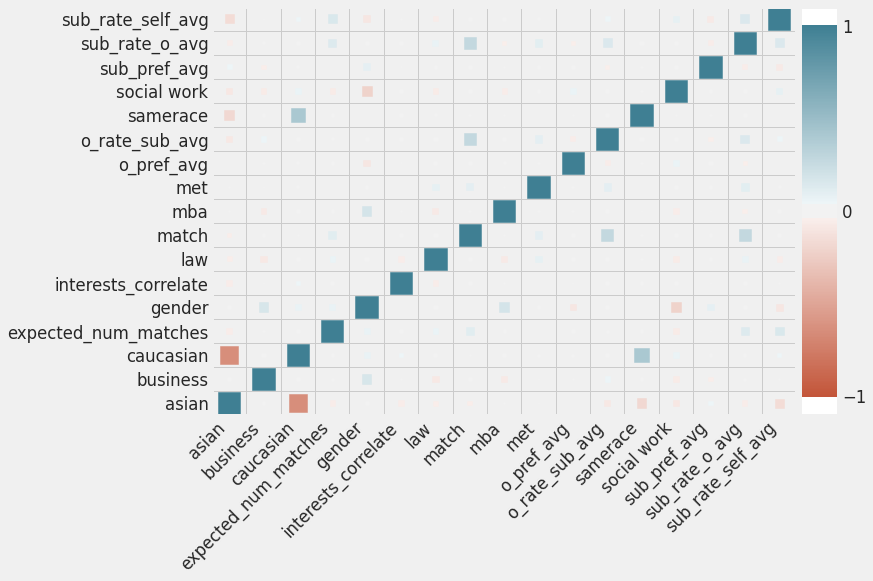

In [55]:
# Make correlation heatmap
plt.style.use('fivethirtyeight')
def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(10,7))
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot

    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 
    

corr = df_corr.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

##### Target column ('Match'):
- Positive correlation with partner rating of subject & subject rating of partner

##### Misc:
- Expected negative correlation between (caucasian & asian) and (age_diff & f_age). No valuable info.
- Expected positive correlation between (caucasian & samerace) due to majority of caucasians in sample.

###### <br>

## Model Fitting

- Looking to keep most individual rating columns in the modeling dataframe since (8000+ rows, 40+ columns) is a manageable dimension.
- Logistic Regression, Random Forest, SVM (\*normalization needed) are preliminary candidates for our binary classification problem.

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler  # For SVM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [57]:
# Remove aggregate rating columns since will be keeping the individual ones
df_model = df_conv.drop(columns=df_conv.filter(regex='_avg$'))

In [58]:
print(list(df_model.columns.values))

['gender', 'samerace', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner', 'interests_correlate', 'expected_num_matches', 'met', 'match', 'f_age', 'm_to_f_agediff', 'caucasian', 'asian', 'business', 'law', 'mba', 'social work']


In [59]:
# Reorder columns
df_model = df_model[['gender', 'f_age', 'm_to_f_agediff', 'caucasian', 'asian', \
                  'samerace', 'business', 'law', 'mba', 'social work', \
                  'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', \
                  'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', \
                  'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', \
                  'shared_interests_o', 'attractive_important', 'sincere_important', \
                  'intelligence_important', 'funny_important', 'ambition_important', \
                  'shared_interests_important', 'attractive', 'sincere', 'intelligence', \
                  'funny', 'ambition', 'attractive_partner', 'sincere_partner', \
                  'intelligence_partner', 'funny_partner', 'ambition_partner', \
                  'shared_interests_partner', 'interests_correlate', 'expected_num_matches', \
                  'met', 'match']]

In [60]:
df_model.head()

,gender,f_age,m_to_f_agediff,caucasian,asian,samerace,business,law,mba,social work,...,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,met,match
0,0,21,6,0,1,0,0,1,0,0,...,6.0,9.0,7.0,7.0,6.0,5.0,0.14,4.0,0.0,0
1,0,21,1,0,1,0,0,1,0,0,...,7.0,8.0,7.0,8.0,5.0,6.0,0.54,4.0,1.0,0
2,0,21,1,0,1,1,0,1,0,0,...,5.0,8.0,9.0,8.0,5.0,7.0,0.16,4.0,1.0,1
3,0,21,2,0,1,0,0,1,0,0,...,7.0,6.0,8.0,7.0,6.0,8.0,0.61,4.0,0.0,1
4,0,21,3,0,1,0,0,1,0,0,...,5.0,6.0,7.0,7.0,6.0,6.0,0.21,4.0,0.0,1


In [61]:
# Train-Test Split
X = df_model.drop('match', axis=1).values
y = df_model['match'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 1, stratify = y)

### Logistic Regression

In [62]:
# Logistic Regression
param_grid = {'C': np.logspace(-5, 8, 15)}
logreg = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=1)

logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

print('Best parameter value: ', logreg_cv.best_params_)

Best parameter value:  {'C': 163789.3706954068}


Optimized Logistic Regression Accuracy Score:  0.8492257538712307
Optimized Logistic Regression ROC/AUC Score:  0.8153294465085723


''

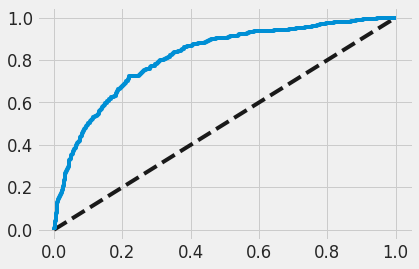

In [63]:
# Model Logistic Regression with optimized parameter
logreg_opt = LogisticRegression(solver='lbfgs',
                                C=3.73,
                                random_state=1,
                                n_jobs=-1)
logreg_opt.fit(X_train, y_train)
y_pred_logreg = logreg_opt.predict(X_test)

# Calculate Accuracy Score
print('Optimized Logistic Regression Accuracy Score: ', accuracy_score(y_test,
                                                                       y_pred_logreg))

#Plot ROC Curve
y_pred_prob_logreg = logreg_opt.predict_proba(X_test)[:,1]
fpr_logreg, tpr_logreg, threshold_logreg = roc_curve(y_test, y_pred_prob_logreg)

print('Optimized Logistic Regression ROC/AUC Score: ', roc_auc_score(y_test,
                                                                     y_pred_prob_logreg))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_logreg, tpr_logreg)
;

### SVM

In [64]:
# SVM
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(random_state=1))]

pipeline = Pipeline(steps)

parameters = {'SVM__C' :[1, 10, 100],
              'SVM__gamma' :[0.1, 0.01]}

svm_cv = GridSearchCV(pipeline, parameters, cv=5)
svm_cv.fit(X_train, y_train)

print('Best parameters: ', svm_cv.best_params_)

Best parameters:  {'SVM__C': 10, 'SVM__gamma': 0.01}


In [65]:
# Model SVM with optimized parameters
svm_opt = SVC(random_state=1,
              C=10,
              gamma=0.01)
steps = [('scaler', StandardScaler()),
         ('SVM', svm_opt)]

pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
y_pred_svm = pipeline.predict(X_test)

# Calculate Accuracy Score
print('Optimized SVM Accuracy Score: ', accuracy_score(y_test, y_pred_svm))

Optimized SVM Accuracy Score:  0.8557457212713936


### Random Forest

In [66]:
# GridSearch Random Forest to optimize parameters
rfc = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators' :[100, 300, 500, 800, 1200],
              'max_depth' :[5, 8, 15, 25, 30],
              'min_samples_split' :[2, 5, 10, 15, 100],
              'min_samples_leaf' :[1, 2, 5, 10]}

rfc_cv = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
rfc_cv.fit(X_train, y_train)

print('Best parameters: ', rfc_cv.best_params_)

Best parameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


Optimized Random Forest Classifier Accuracy Score:  0.8561532192339039
Optimized Random Forest Classifier ROC/AUC Score:  0.8210737847421762


''

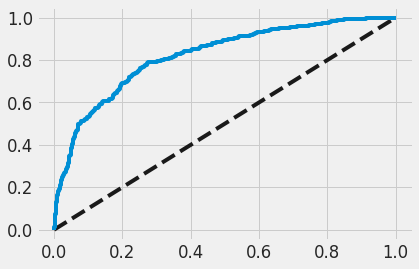

In [67]:
# Model random forest with optimized parameters
rfc_opt = RandomForestClassifier(random_state=1,
                                 max_depth=15,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 n_estimators=500)
rfc_opt.fit(X_train, y_train)
y_pred_rfc = rfc_opt.predict(X_test)

#Accuracy Score
print('Optimized Random Forest Classifier Accuracy Score: ', accuracy_score(y_test,
                                                                            y_pred_rfc))

#Plot ROC curve
y_pred_prob_rfc = rfc_opt.predict_proba(X_test)[:,1]
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test, y_pred_prob_rfc)

print('Optimized Random Forest Classifier ROC/AUC Score: ', roc_auc_score(y_test,
                                                                          y_pred_prob_rfc))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_rfc, tpr_rfc)
;

#### \*Best Model
The **Random Forest Classifier** ended up edging over the other models with an accuracy score of **85.6%**. 
<br><br>
Being a black-box model, not much additional insight can be garnered from a random forest, mostly in regards to coefficient importance. That said, we can look at the coefficients through the logistic regression model which doesn't trail far behind with an accuracy score of 84.9%.

''

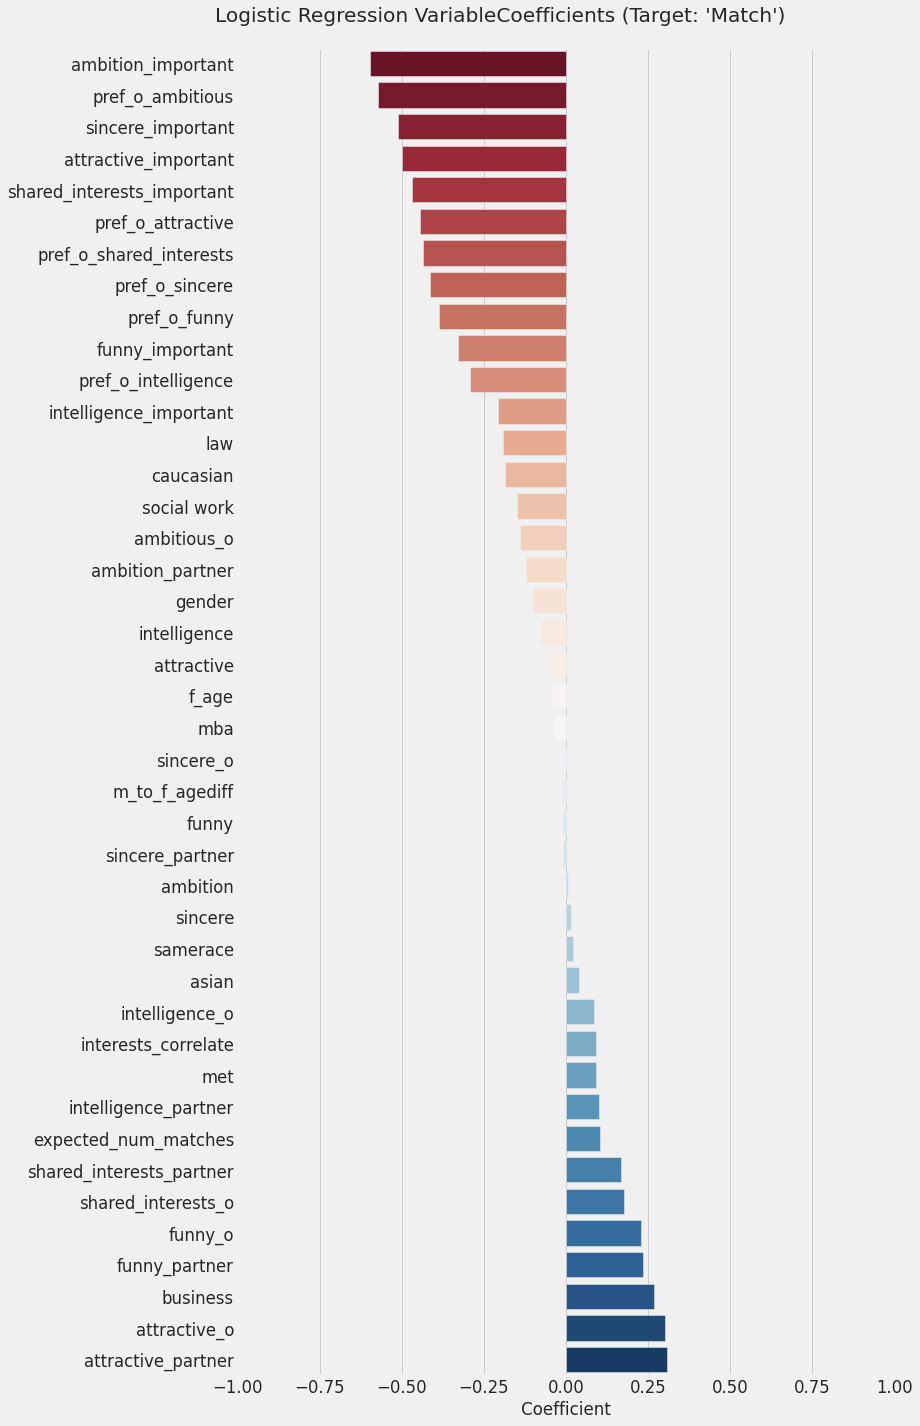

In [72]:
coef_dict = {'Variable': list(df_model.drop('match', axis=1).columns),
             'Coefficient': logreg_opt.coef_.tolist()[0]}

df_coef = pd.DataFrame.from_dict(coef_dict)
df_coef = df_coef.sort_values(by='Coefficient')

fig = plt.figure(figsize=(13, 20))
sns.barplot(x='Coefficient', y='Variable', data=df_coef, palette='RdBu')
plt.ylabel('')
plt.xlim(-1, 1)
plt.title('Logistic Regression VariableCoefficients (Target: \'Match\')',
          x=0.4, y=1.015)
plt.tight_layout()
plt.savefig('./figure/logistic_regression_variable_coefficients.png')
;

Negative features have more influence on the model. The **attractiveness** and **humor** ratings of each other were the most positive factors. Generally speaking, the higher the **expectations** each other had coming in, the lower the chance of a match was.

Somewhat surprisingly, being caucasian was negatively associated with a match, while being asian was positive. Being in the business field apparently boosted your chances, while working in law worked the other way.